KAGGLE + COLAB SET UP

1. Uploading kaggle.json  & moving file to correct location

In [ ]:
# Delete the existing (non-git) folder
!rm -rf /content/deep-xray-diagnosis-machkevds

# Clone the GitHub repo cleanly
!git clone https://github.com/machkevds/deep-xray-diagnosis-machkevds.git

# Move into the repo
%cd /content/deep-xray-diagnosis-machkevds


Cloning into 'deep-xray-diagnosis-machkevds'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 786.23 KiB | 5.78 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/deep-xray-diagnosis-machkevds


In [ ]:
import os
os.getcwd()


'/content/deep-xray-diagnosis-machkevds'

In [ ]:
!git config --global user.name "machkevds"
!git config --global user.email "kevindslzr@gmail.com"


In [ ]:
#UPDATE
# Inside your repo folder after OPENING THE GITHUB NOTEBOOK WITHIN COLAB!!!

YOUR_TOKEN = ""

!git add xray-diag-machkds.ipynb
!git commit -m "Update: GIT SETUP"

# Push using the token variable — this is the key change:
!git push https://{YOUR_TOKEN}@github.com/machkevds/deep-xray-diagnosis-machkevds.git main


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [1]:
from google.colab import files
files.upload() # upload kaggle json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"machkevds","key":"678fe96424c7399770a2ab98c064ba38"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:18<00:00, 173MB/s]
100% 2.29G/2.29G [00:18<00:00, 130MB/s]


2. Exploring dataset structure &visualizing sample images

In [6]:
import os

#root folder of dataset
data_dir = "./data/chest_xray"

#loop over train val and test directories
#for each split go into its folder & subfolders "3 labels"
for split in ["train", "val", "test"]:
  split_path = os.path.join(base_dir, split)
  print(f"\n{split.upper()} SET:")

#for each label, count number of images it contains
  for label in os.listdir(split_path):
    label_path = os.path.join(split_path, label)
    count = len(os.listdir(label_path))
    print(f" - {label}: {count} images")


TRAIN SET:
 - PNEUMONIA: 3875 images
 - NORMAL: 1341 images

VAL SET:
 - PNEUMONIA: 8 images
 - NORMAL: 8 images

TEST SET:
 - PNEUMONIA: 390 images
 - NORMAL: 234 images


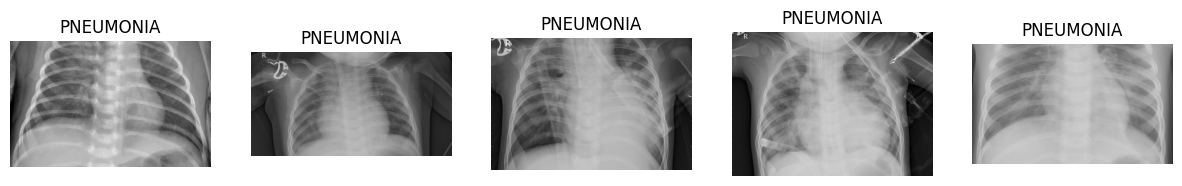

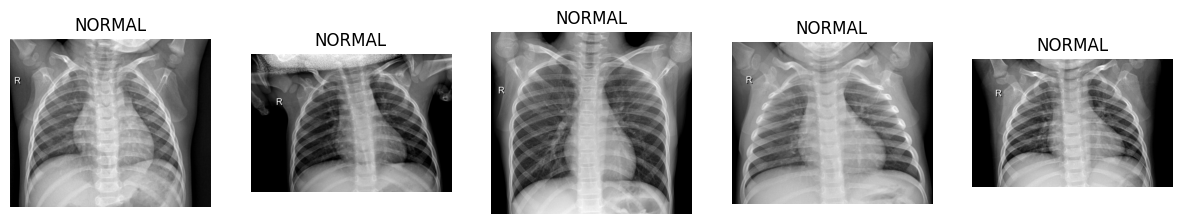

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_random_images(split="train", label="PNEUMONIA", num=5):
  path = os.path.join(base_dir, split, label)
  files = random.sample(os.listdir(path), num)

  plt.figure(figsize=(15,3))
  for i, f in enumerate(files):
    img = mpimg.imread(os.path.join(path, f))
    plt.subplot(1, num, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(label)
  plt.show()

show_random_images("train", "PNEUMONIA")
show_random_images("train", "NORMAL")

3. Data Preprocessing (Keras)

In [8]:
#importing libraries and defining paths

import tensorflow as tf
from tensorflow.keras import layers
import os

#set base paths
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

#set standard image size for CNNs
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [9]:
# load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_Split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # for consistent test evaluation, confusion matrix?
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# DATA AUGMENTATION added on KEVPOCH 3
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlipt("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

4. Building a CNN from scratch in Keras (TensorFlow)

In [12]:
# building the CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # first convolution + pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2,2)),

    # second convolution + pooling
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    #third convolution + pooling
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # flatten & fully connect layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), #helps with overfitting
    Dense(1, activation='sigmoid') #binary classification w sigmoid
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# compile the model

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# adding CALLBACKS added on KEVPOCH 3

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

In [15]:
# train the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
    callbacks=callbacks # added on KEVPOCH 3
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.7678 - loss: 13.6983 - val_accuracy: 0.8750 - val_loss: 0.3514
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - accuracy: 0.9335 - loss: 0.1964 - val_accuracy: 0.9375 - val_loss: 0.2700
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.9482 - loss: 0.1582 - val_accuracy: 0.9375 - val_loss: 0.2461
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step - accuracy: 0.9599 - loss: 0.1211 - val_accuracy: 0.9375 - val_loss: 0.3015
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.9701 - loss: 0.0933 - val_accuracy: 0.8750 - val_loss: 0.3494
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.9669 - loss: 0.0868 - val_accuracy: 0.7500 - val_loss: 0.5968
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.9734 - loss: 0.0672 - val_accuracy: 0.7500 - val_loss: 1.2758
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.9717 - loss: 

In [16]:
# evaluation
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5213 - loss: 3.9925
Test Accuracy: 0.7372


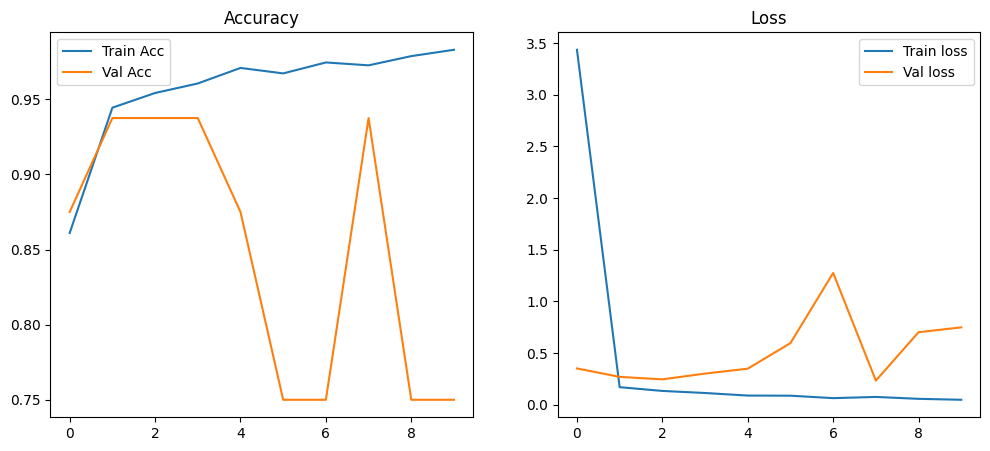

In [17]:
# plot training and validation performance

import matplotlib.pyplot as plt

def plot_training(history):
  acc= history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 5))

  plt.subplot(1,2,1)
  plt.plot(acc, label="Train Acc")
  plt.plot(val_acc, label="Val Acc")
  plt.title('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(loss, label='Train loss')
  plt.plot(val_loss, label="Val loss")
  plt.title('Loss')
  plt.legend()

  plt.show()

plot_training(history)

In [ ]:
# NOTES:

#KEVPOCH 1 (personal term to track my changes to the models)
# overfitting:
#so I increased dropout to 0.6, added validation_split, increased rotation_range from 15 to 30, epochs from 10 to 15
# I noticed that ImageDataGenerator is DEPRECATED, so I will definetely move to a modern approach, will use image_dataset_from_directory
# this attempt failed and caused ever worse overfitting, so now I will revert changes to original and commit on github for tracking.
# you also forgot to add the validation loss curve on the loss graph, it will now be added


#KEVPOCH 2 TEST 2 IS IT COMMITED?
# RESULTS
# commiting was succesful, OPEN GITHUB NOTEBOOK from the colab dashborad, and finalyl you need to save with Ctrl+S and then it will open a commit tab
# migrated to modern approach, trained again, train acc 98% validation starts at 93% then drops to 75%, then spikes back up and down
# loss graph has some overfitting, test loss is 3.o9 meaning the loss from the model tested on raw non augmented test data
# model is overfitting

#KEVPOCH 3
# BEFORE RUNNING
# few questions asked to identify any possible flaws:
# How many samples are there in each split? 3875 for PNEUMONIA and NORMAL 1341, sufficient but NOT BALAnced ~3:1 in favor of pneumonia
# Dropout being used? Yes
# Using data augmentation? No, could be a key reason for overfitting | train acc = 98%, test acc = 74%, test loss = high 3.9...
# Are images similar? Yeah, they obviously are, thats why its hard to generalize when its at risk of memorization,

# CHANGES
# Will add data augmentation and possibly transfer learning.
# RESULTS

@@@ GITHUB SETUP @@@

In [ ]:
import os

# Replace with your info
os.environ['USER'] = 'machkevds'
os.environ['REPO'] = 'deep-xray-diagnosis-machkevds'

# Clone repo
%cd /content
!rm -rf {os.environ['REPO']}  # Remove old clone if needed
!git clone https://github.com/{os.environ['USER']}/{os.environ['REPO']}.git

# Go into repo
%cd /content/{os.environ['REPO']}
!git config --global user.name "machkevds"
!git config --global user.email "kevindslzr@gmail.com"


/content
Cloning into 'deep-xray-diagnosis-machkevds'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/deep-xray-diagnosis-machkevds


In [ ]:
!ls /content/*.ipynb


/content/xray-diag-machkds.ipynb


In [ ]:
# Replace with your actual notebook name if different
notebook_name = "xray-diag-machkds.ipynb"

# Move notebook into repo folder
!mv /content/{notebook_name} /content/{os.environ['REPO']}


In [ ]:
# Inside repo
%cd /content/{os.environ['REPO']}
!git add {notebook_name}
!git commit -m "Add notebook with initial CNN model 2:20pm"


/content/deep-xray-diagnosis-machkevds
[main 067cade] Add notebook with initial CNN model 2:20pm
 1 file changed, 1 insertion(+)
 create mode 100644 xray-diag-machkds.ipynb


In [ ]:
# Replace with new GitHub token (classic, repo scope)
GITHUB_TOKEN = ""

!git push https://{GITHUB_TOKEN}@github.com/{os.environ['USER']}/{os.environ['REPO']}.git main


remote: Repository not found.
fatal: repository 'https://github.com/{os.environ[USER]}/{os.environ[REPO]}.git/' not found
